In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

Source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000201

In [3]:
df = pd.read_csv('../data/monthly_avg_retail_price_food_canada.csv')
df.head()

,REF_DATE,GEO,DGUID,Products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1995-01,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.17,NaN,NaN,NaN,2
1,1995-02,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.29,NaN,NaN,NaN,2
2,1995-03,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.12,NaN,NaN,NaN,2
3,1995-04,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.38,NaN,NaN,NaN,2
4,1995-05,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.00,NaN,NaN,NaN,2


In [4]:
df.shape

(16166, 15)

In [5]:
df = df[df['Products'] == 'Round steak, 1 kilogram']
df.head()

,REF_DATE,GEO,DGUID,Products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1995-01,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.17,NaN,NaN,NaN,2
1,1995-02,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.29,NaN,NaN,NaN,2
2,1995-03,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.12,NaN,NaN,NaN,2
3,1995-04,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.38,NaN,NaN,NaN,2
4,1995-05,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.00,NaN,NaN,NaN,2


In [6]:
df.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Products', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')

In [7]:
cols_to_drop = ['GEO', 'DGUID', 'Products', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS']

df = df.drop(cols_to_drop, axis=1)
df.head()

,REF_DATE,VALUE
0,1995-01,10.17
1,1995-02,10.29
2,1995-03,10.12
3,1995-04,10.38
4,1995-05,10.00


In [8]:
df.shape

(323, 2)

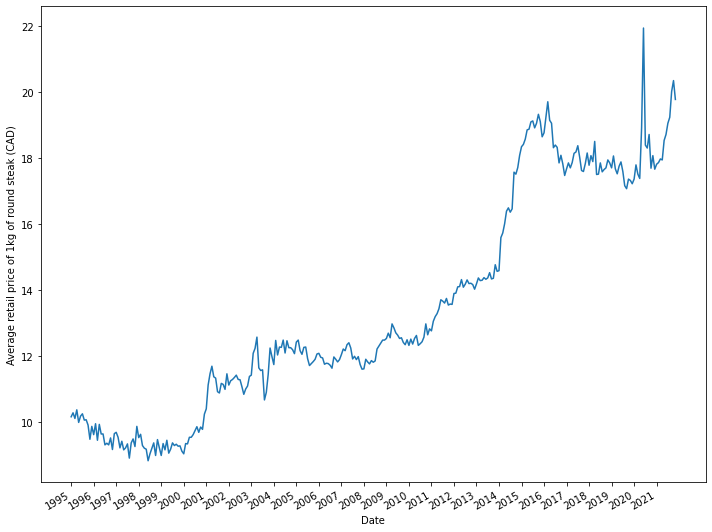

In [9]:
fig, ax = plt.subplots()

ax.plot(df['VALUE'])
ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH20_F01_peixeiro.png', dpi=300)

In [10]:
df.columns = ['ds', 'y']

In [11]:
from pandas.tseries.offsets import MonthEnd

df['ds'] = pd.to_datetime(df['ds']) + MonthEnd(1)

df.head()

,ds,y
0,1995-01-31,10.17
1,1995-02-28,10.29
2,1995-03-31,10.12
3,1995-04-30,10.38
4,1995-05-31,10.00


In [12]:
train = df[:-36]
test = df[-36:]

train.tail()

,ds,y
282,2018-07-31,17.85
283,2018-08-31,17.58
284,2018-09-30,17.65
285,2018-10-31,17.70
286,2018-11-30,17.94


In [13]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

cutoffs = pd.date_range(start='2000-01-31', end='2018-11-30', freq='36M')

for param in params:
    m = Prophet(**param)
    m.fit(train)
    
    df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
best_params = params[np.argmin(mses)]
print(best_params)

{'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


In [13]:
best_params = {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}

In [14]:
m = Prophet(**best_params)
m.fit(train);

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
future = m.make_future_dataframe(periods=36, freq='M')

In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
311,2020-12-31,19.201103,17.594496,20.992069
312,2021-01-31,19.197114,17.497177,20.963513
313,2021-02-28,19.529940,17.778656,21.448957
314,2021-03-31,19.454047,17.481243,21.468551
315,2021-04-30,19.579023,17.631457,21.812786
316,2021-05-31,19.523268,17.325974,21.899161
317,2021-06-30,19.450911,17.212936,21.809140
318,2021-07-31,19.413770,17.039854,21.857315
319,2021-08-31,19.399993,16.927093,21.873524
320,2021-09-30,19.409117,16.720742,22.096282


In [17]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
287,2018-12-31,17.85,18.590765,17.883762,19.256819
288,2019-01-31,17.70,18.576558,17.863099,19.218066
289,2019-02-28,18.06,18.758135,18.062118,19.472700
290,2019-03-31,17.67,18.784061,18.066630,19.505918
291,2019-04-30,17.52,19.036426,18.358767,19.699732


In [18]:
test['Baseline'] = train['y'].iloc[-1]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,Baseline
287,2018-12-31,17.85,18.590765,17.883762,19.256819,17.94
288,2019-01-31,17.70,18.576558,17.863099,19.218066,17.94
289,2019-02-28,18.06,18.758135,18.062118,19.472700,17.94
290,2019-03-31,17.67,18.784061,18.066630,19.505918,17.94
291,2019-04-30,17.52,19.036426,18.358767,19.699732,17.94


In [19]:
baseline_mae = mean_absolute_error(test['y'], test['Baseline'])
prophet_mae = mean_absolute_error(test['y'], test['yhat'])

print(prophet_mae)
print(baseline_mae)

1.1625486870355015
0.6816666666666671


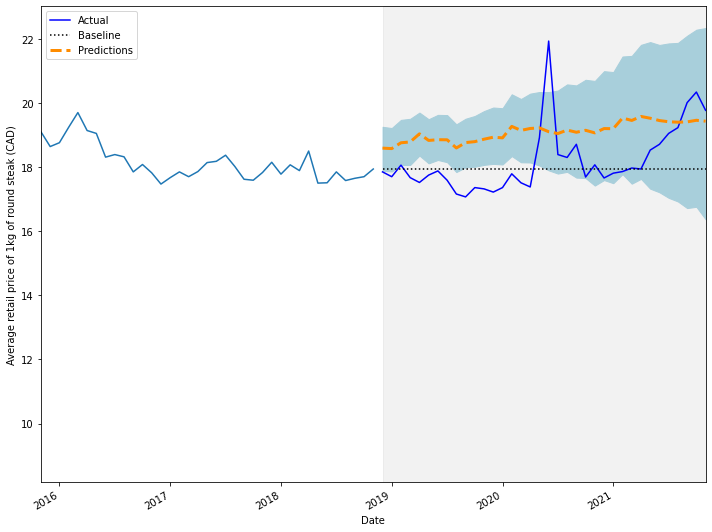

In [20]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['Baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

ax.axvspan(287, 322, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(250, 322)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH20_F02_peixeiro.png', dpi=300)

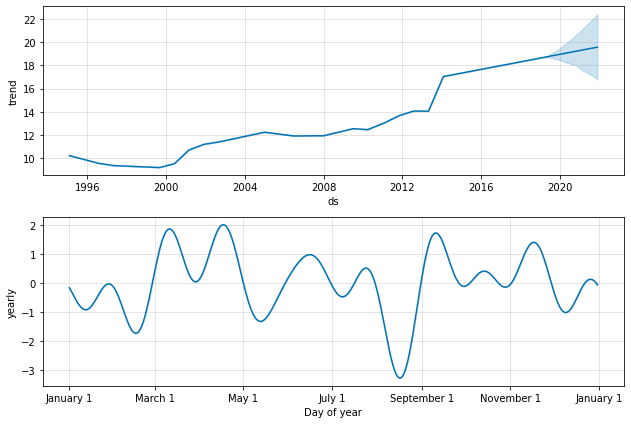

In [21]:
prophet_components_fig = m.plot_components(forecast)

plt.savefig('figures/CH20_F03_peixeiro.png', dpi=300)

## SARIMA 

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from typing import Union

In [23]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.31276604677391173
p-value: 0.9779226633224507


In [24]:
y_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.784744900608825
p-value: 1.2558701587332173e-29


In [25]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [26]:
ps = range(1, 4, 1)
qs = range(1, 4, 1)
Ps = range(1, 4, 1)
Qs = range(1, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 12

In [28]:
SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to conver

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to conver

,"(p,q,P,Q)",AIC
0,"(2, 3, 1, 1)",59.264870
1,"(3, 2, 1, 1)",60.676823
2,"(2, 3, 1, 2)",60.863847
3,"(2, 3, 2, 1)",60.908846
4,"(2, 3, 3, 1)",61.742560
...,...,...
75,"(3, 3, 1, 2)",78.292930
76,"(3, 3, 1, 1)",78.437991
77,"(3, 3, 1, 3)",78.747225
78,"(3, 3, 3, 3)",79.510984


In [27]:
SARIMA_model = SARIMAX(train['y'], order=(2,1,3), seasonal_order=(1,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  287
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 -21.632
Date:                              Mon, 17 Jan 2022   AIC                             59.265
Time:                                      19:01:24   BIC                             88.513
Sample:                                           0   HQIC                            70.988
                                              - 287                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2161      0.040     30.290      0.000       1.137       1.295
ar.L2         -0.92

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


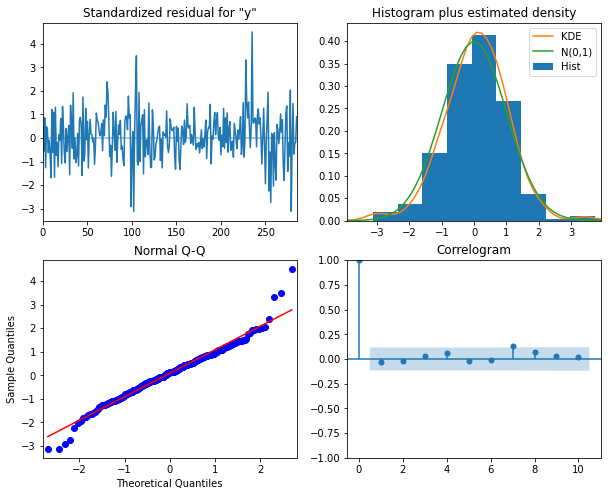

In [28]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH20_F04_peixeiro.png', dpi=300)

In [29]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.95610034 0.95440704 0.97306023 0.98540492 0.99613749 0.99903243
 0.99977675 0.99994573 0.99998369 0.99993006]


In [30]:
SARIMA_pred = SARIMA_model_fit.get_prediction(287, 322).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

In [31]:
SARIMA_mae = mean_absolute_error(test['y'], test['SARIMA_pred'])

print(SARIMA_mae)

0.6777050081111813


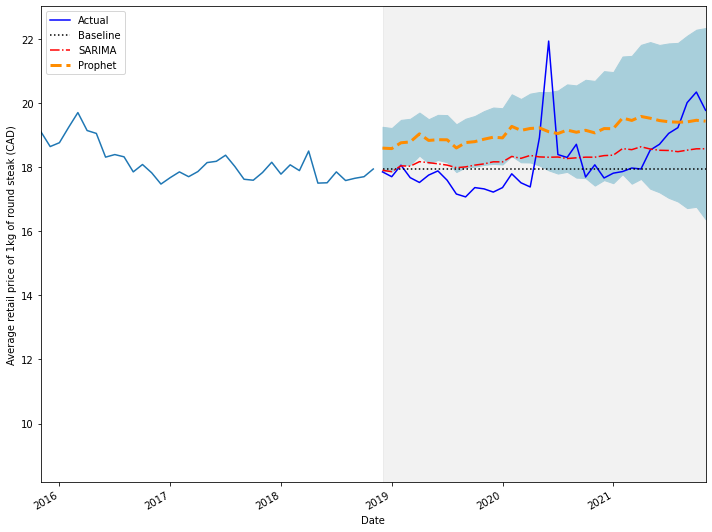

In [33]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['Baseline'], 'k:', label='Baseline')
ax.plot(test['SARIMA_pred'], 'r-.', label='SARIMA')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Prophet')

ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

ax.axvspan(287, 322, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(250, 322)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH20_F05_peixeiro.png', dpi=300)